### Q1. Explain, in detail, the above transform methods

Square transform : 

x2 can reduce left skewness. It has a medium effect on data

Log transform :

Time series with an exponential distribution can be made linear by taking the logarithm of the values

Square root transform:

Simply take the square root of your variables, i.e. x → x(1/2) = sqrt(x). This will have a moderate effect on the distribution  and usually works for data with non-constant variance. However, it is considered to be weaker than logarithmic or cube root transforms and also used for reducing right skewness and also has the advantage that it can be applied to zero values.

Box Cox transform:

it is used when you need to meet the assumption of normality for a statistical test or procedure. It transform non-normal dependent variables into a normal shape.(stabilize the variance)

#### Q2: Perform similar transformations to the temperature dataset. 

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import DataFrame
from pandas import concat
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import seasonal_decompose
register_matplotlib_converters()
register_matplotlib_converters()
plt.rcParams["figure.figsize"] = [16,9]
from statistics import *
import seaborn as sns
sns.set()


In [2]:
data = pd.read_csv(r"C:\Users\Madhukar\Documents\Mechine_learning\Projects\Time_series_Arima\testset.csv")

In [3]:
#using interpolate method to impute the missing values
data['Temperature'] = data.Temperature.interpolate(method='linear')

In [4]:
#datetime format
data['datetime'] = pd.to_datetime(data['datetime'].apply(lambda x: datetime.strptime(x,"%Y%m%d-%H:%M").strftime("%Y-%m-%d %H:%M")))

In [5]:
data = data.set_index('datetime',drop=True)
data.index.name = 'datetime'

In [6]:
# using IQR method to display outlier data,IQR is the first quartile subtracted from the third quartile
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Temperature    13.0
dtype: float64


In [7]:
# removing the outlayers
data_out= data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]
data_out.shape

(100986, 1)

In [8]:
#excluding the missing and retaining years of 12 months data
data = data_out['2001':'2016']
data.shape

(76507, 1)

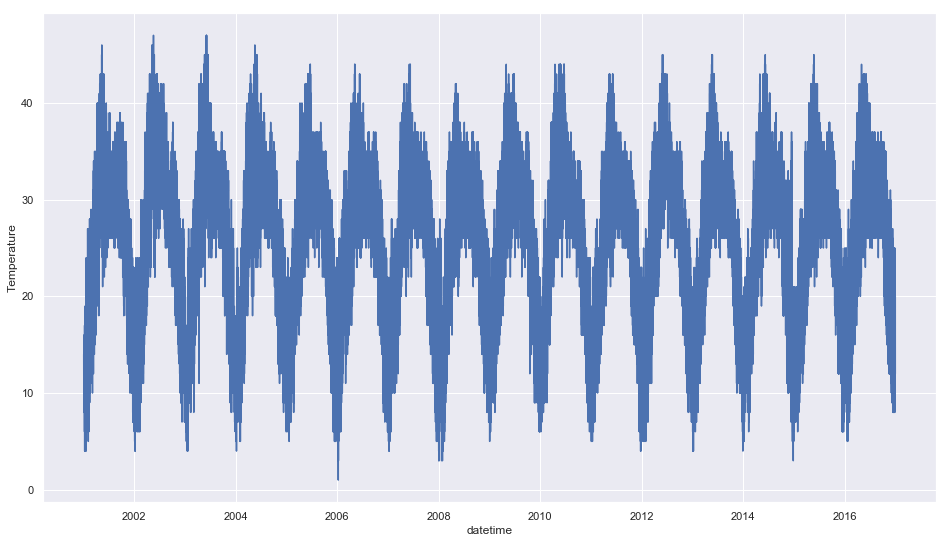

In [11]:
plt.xlabel('datetime')
plt.ylabel('Temperature')
plt.plot(data)

### From the above charts,seasonal variation is having same magnitude across time so we can use additive model.

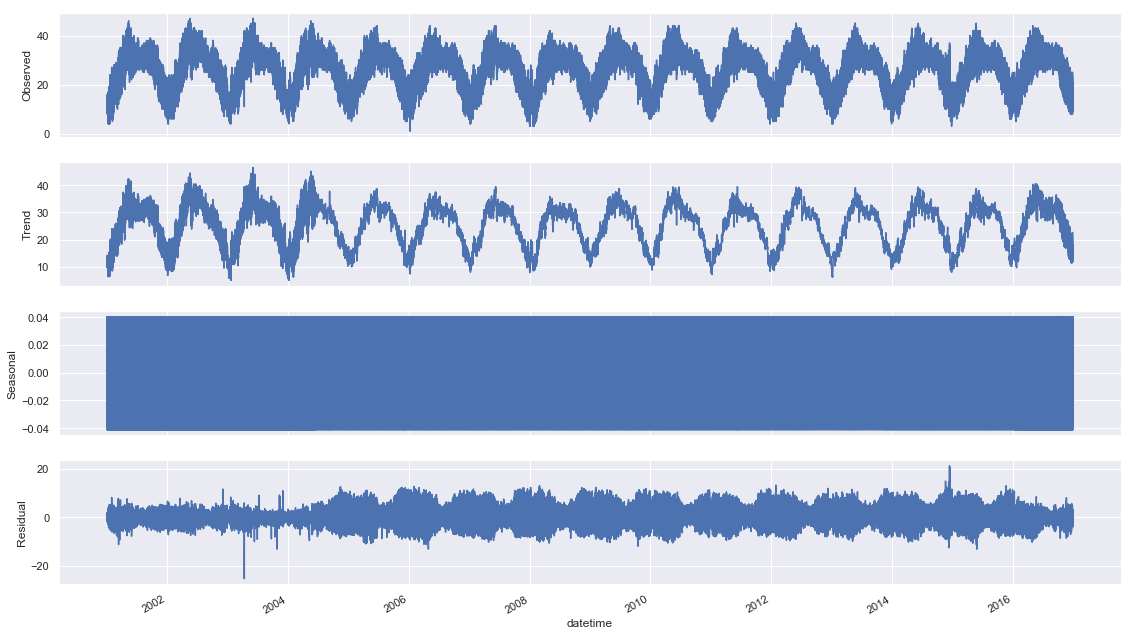

In [56]:
result = seasonal_decompose(data, model='additive',freq=12)
result.plot()
plt.show()

### From the above decompose chart we can see Stochastic trend, seasonal variation is constant over time and with some errors.

In [ ]:
data1=data.reset_index()
data1['datetime'] = pd.to_datetime(data1['datetime'])

In [15]:
ts = pd.Series(data1['Temperature'].values, index=data1['datetime'])

In [36]:
train = ts[:'2012']
test = ts['2013':]

In [17]:
# applying ADF to check if the series is stationary or not
from statsmodels.tsa.stattools import adfuller
def stationarity_check(tss):
    
    # Determing rolling statistics
    roll_mean = tss.rolling(window=12).mean()
    movingstd= tss.rolling(window=12).std()
    # Plot rolling statistics:
    plt.plot(tss, color='green',label='Original')
    plt.plot(roll_mean, color='blue', label='Rolling Mean')
    plt.plot(movingstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Std')
    plt.show(block=False)
    
    
    # Perform Augmented Dickey-Fuller test:
    print('Augmented Dickey-Fuller test:')
    df_test = adfuller(tss)
    print("type of df_test: ",type(df_test))
    print("df_test: ",df_test)
    df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print("df_output: \n",df_output)
    for key,value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value
    print(df_output)

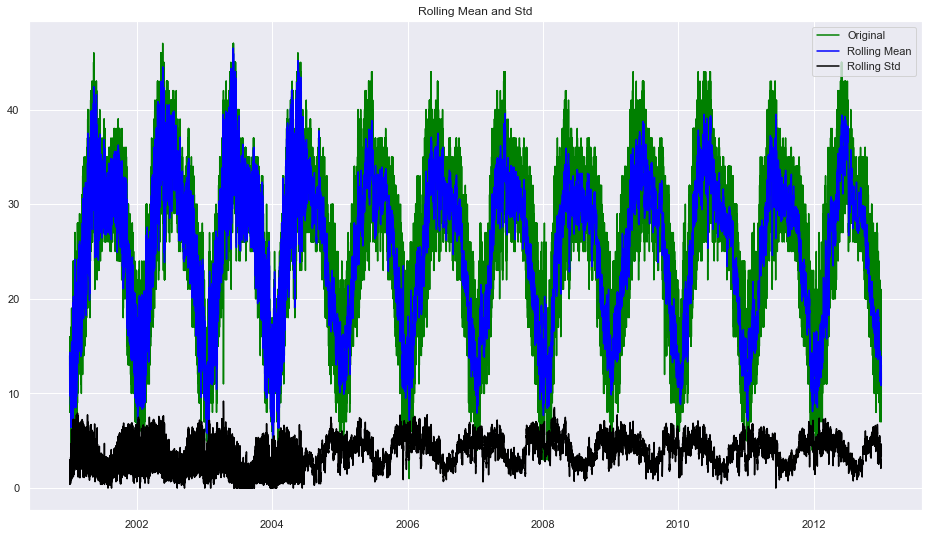

Augmented Dickey-Fuller test:
type of df_test:  <class 'tuple'>
df_test:  (-5.5690130983609185, 1.4820604032294555e-06, 59, 61477, {'1%': -3.430456374303662, '5%': -2.8615870154510126, '10%': -2.5667950247359483}, 244394.77547987585)
df_output: 
 Test Statistic                    -5.569013
p-value                            0.000001
#Lags Used                        59.000000
Number of Observations Used    61477.000000
dtype: float64
Test Statistic                    -5.569013
p-value                            0.000001
#Lags Used                        59.000000
Number of Observations Used    61477.000000
Critical Value (1%)               -3.430456
Critical Value (5%)               -2.861587
Critical Value (10%)              -2.566795
dtype: float64


In [38]:
stationarity_check(train)

### From the above ADF test, p< 0.05 implies that the series does not have a unit root and is stationary and test statistics < critical values of confidence levels, so we reject null hypothesis and the series is stationary.

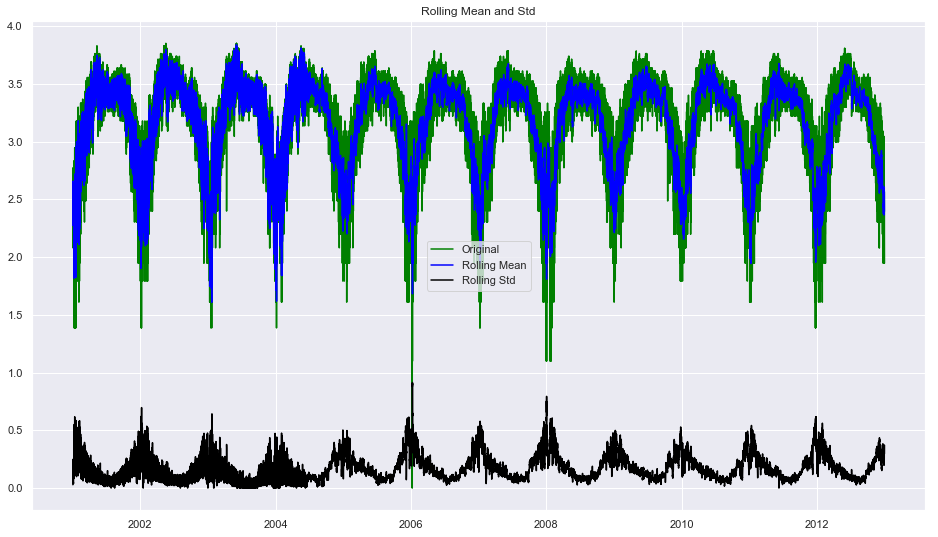

Augmented Dickey-Fuller test:
type of df_test:  <class 'tuple'>
df_test:  (-5.827344681423557, 4.05020735462097e-07, 60, 61476, {'1%': -3.4304563760340727, '5%': -2.861587016215808, '10%': -2.5667950251430254}, -123195.33833433664)
df_output: 
 Test Statistic                -5.827345e+00
p-value                        4.050207e-07
#Lags Used                     6.000000e+01
Number of Observations Used    6.147600e+04
dtype: float64
Test Statistic                -5.827345e+00
p-value                        4.050207e-07
#Lags Used                     6.000000e+01
Number of Observations Used    6.147600e+04
Critical Value (1%)           -3.430456e+00
Critical Value (5%)           -2.861587e+00
Critical Value (10%)          -2.566795e+00
dtype: float64


In [66]:
# Apply differencing and power transformation to remove trend, sesonality and noise

##log transformation
log_series = np.log(train)
stationarity_check(log_series)

### Differencing of data

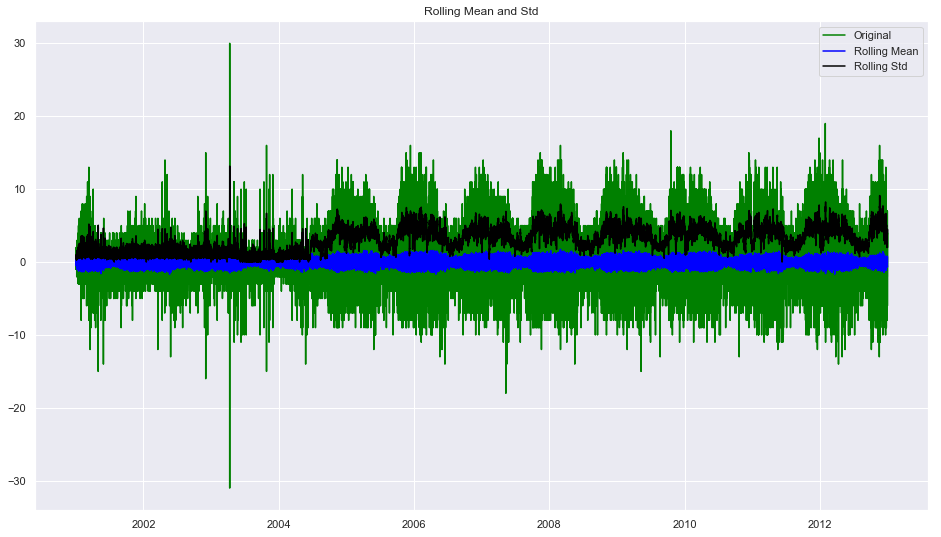

Augmented Dickey-Fuller test:
type of df_test:  <class 'tuple'>
df_test:  (-37.72549274229074, 0.0, 60, 61475, {'1%': -3.43045637776454, '5%': -2.8615870169806286, '10%': -2.5667950255501157}, 244416.96854696638)
df_output: 
 Test Statistic                   -37.725493
p-value                            0.000000
#Lags Used                        60.000000
Number of Observations Used    61475.000000
dtype: float64
Test Statistic                   -37.725493
p-value                            0.000000
#Lags Used                        60.000000
Number of Observations Used    61475.000000
Critical Value (1%)               -3.430456
Critical Value (5%)               -2.861587
Critical Value (10%)              -2.566795
dtype: float64


In [61]:
series_diff = train.diff()
series_diff = series_diff.dropna()
stationarity_check(series_diff)

### Differencing on the log transformed data

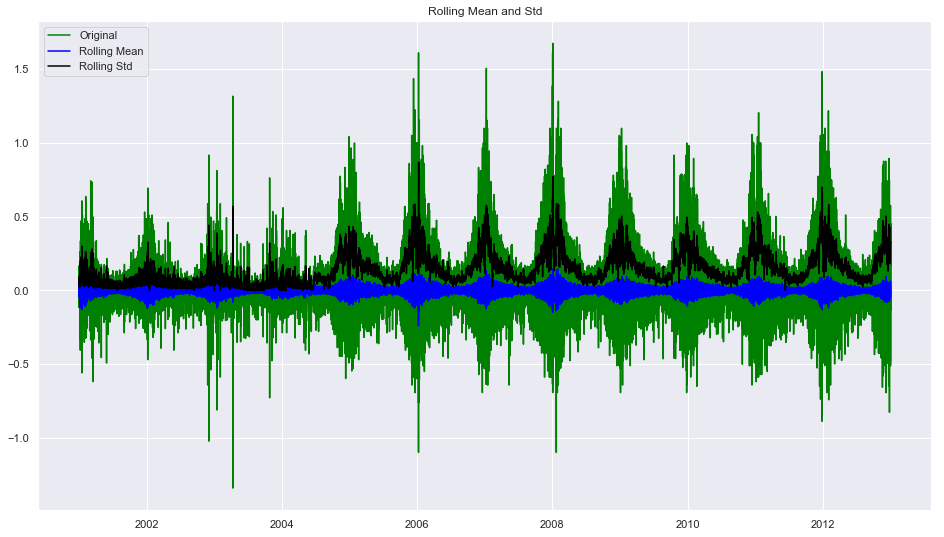

Augmented Dickey-Fuller test:
type of df_test:  <class 'tuple'>
df_test:  (-36.922855302023926, 0.0, 60, 61475, {'1%': -3.43045637776454, '5%': -2.8615870169806286, '10%': -2.5667950255501157}, -123163.91102823103)
df_output: 
 Test Statistic                   -36.922855
p-value                            0.000000
#Lags Used                        60.000000
Number of Observations Used    61475.000000
dtype: float64
Test Statistic                   -36.922855
p-value                            0.000000
#Lags Used                        60.000000
Number of Observations Used    61475.000000
Critical Value (1%)               -3.430456
Critical Value (5%)               -2.861587
Critical Value (10%)              -2.566795
dtype: float64


In [62]:
log_series_diff = log_series.diff()
log_series_diff = log_series_diff.dropna()
stationarity_check(log_series_diff)

### square root transformation

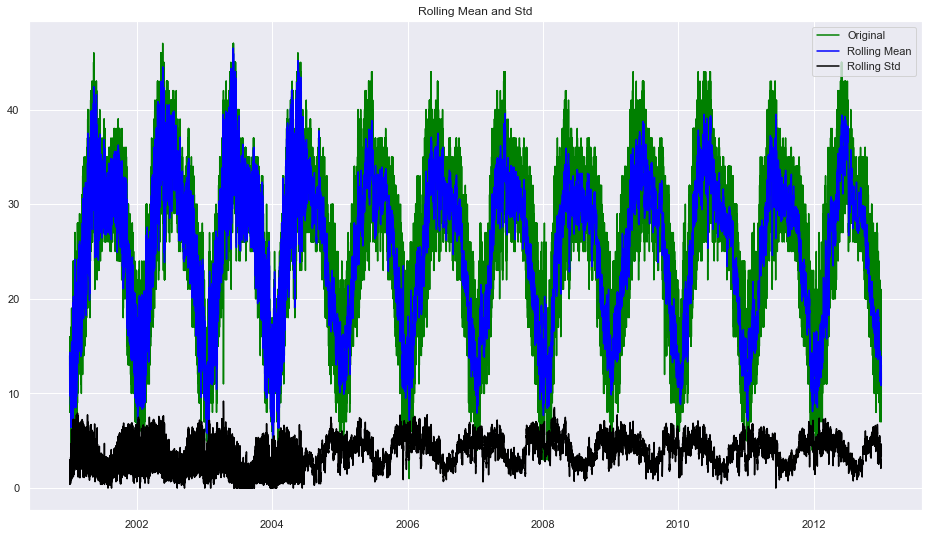

Augmented Dickey-Fuller test:
type of df_test:  <class 'tuple'>
df_test:  (-5.5690130983609185, 1.4820604032294555e-06, 59, 61477, {'1%': -3.430456374303662, '5%': -2.8615870154510126, '10%': -2.5667950247359483}, 244394.77547987585)
df_output: 
 Test Statistic                    -5.569013
p-value                            0.000001
#Lags Used                        59.000000
Number of Observations Used    61477.000000
dtype: float64
Test Statistic                    -5.569013
p-value                            0.000001
#Lags Used                        59.000000
Number of Observations Used    61477.000000
Critical Value (1%)               -3.430456
Critical Value (5%)               -2.861587
Critical Value (10%)              -2.566795
dtype: float64


In [63]:
sqrt_series = np.sqrt(train)
stationarity_check(train)

### subtracting the moving average from the log transformed series

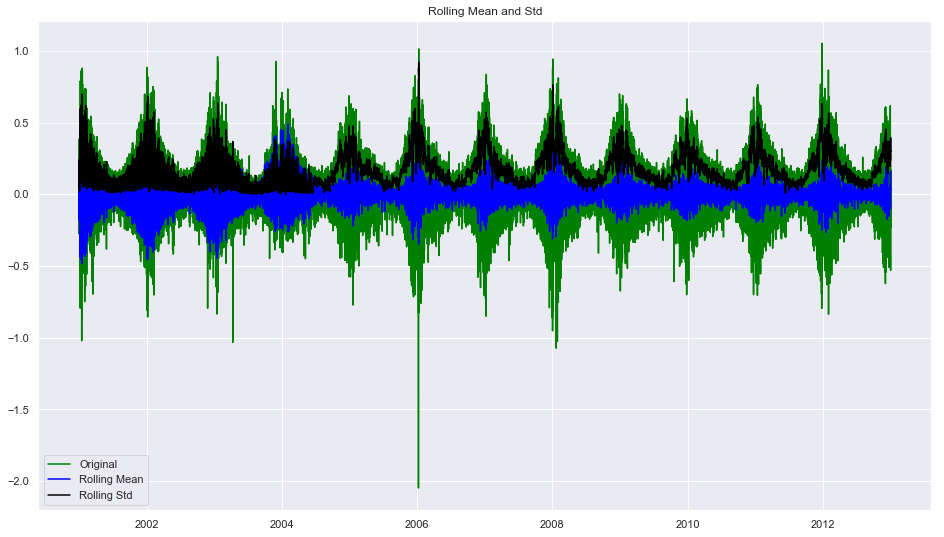

Augmented Dickey-Fuller test:
type of df_test:  <class 'tuple'>
df_test:  (-35.5032908493178, 0.0, 60, 61465, {'1%': -3.43045639507231, '5%': -2.8615870246302015, '10%': -2.566795029621749}, -133900.5672218001)
df_output: 
 Test Statistic                   -35.503291
p-value                            0.000000
#Lags Used                        60.000000
Number of Observations Used    61465.000000
dtype: float64
Test Statistic                   -35.503291
p-value                            0.000000
#Lags Used                        60.000000
Number of Observations Used    61465.000000
Critical Value (1%)               -3.430456
Critical Value (5%)               -2.861587
Critical Value (10%)              -2.566795
dtype: float64


In [64]:
movingAverage = log_series.rolling(window=12).mean()
ma_log_series=log_series-movingAverage
ma_log_series = ma_log_series.dropna()
stationarity_check(ma_log_series)

### Differencing of data transformation has better performance compared to other transformations